## Import modules and functions

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import regionprops

## Define directory of images

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Students/Gabriel/'
protein="TNR" #TNR,Agg,WFA,HABP

## Make a dictionary to store filenames and spots

In [3]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "synapsechannelno":[],
           "Manual syt spots mask":[]}
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "_analyse" in str(filelist[i]):
        if "NCAN" in str(filelist[i]):
            if ("ocus" in str(filelist[i]))==False:
                if ("Pop" in str(filelist[i]))==False:
                    if ("save" in str(filelist[i]))==False:
                        if filelist[i].endswith(".tif"): 
                            if str(filelist[i][:-12]) not in str(results["filename"]):
                                results["filename"].append(filelist[i][:-12])
                                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                exec(open(channeldir+"/channels.txt").read())
                                results["ecmchannelno"].append(1)
                                results["synapsechannelno"].append(2)                                        

## Display a random image

Image name: 07_001_ExpControl
Experimental condition: 4hrs_DMSO


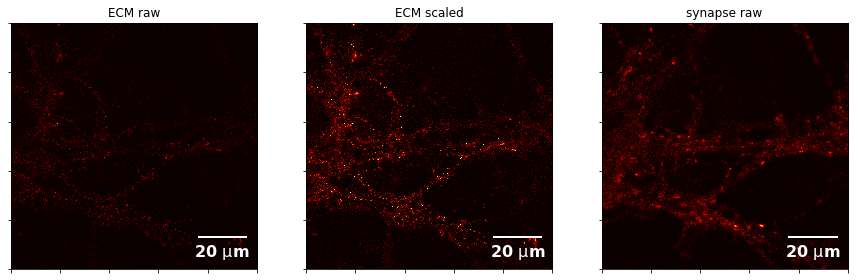

In [4]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=results["ecmchannelno"][randomno]
synapse_channel_no=results["synapsechannelno"][randomno]

ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"

print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
synapse_image=pims.open(synapse_image_name)[0]

figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(synapse_image,interpolation='none',cmap='hot')
plt.title('synapse raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Load spots made in Python widget

In [5]:
for image in range(0,len(results["filename"])):
    results["Manual syt spots mask"].append(np.load(results["filename"][image]+'_syt_spots_mask.npy'))

## Sanity check - see that spots are loaded correctly

60


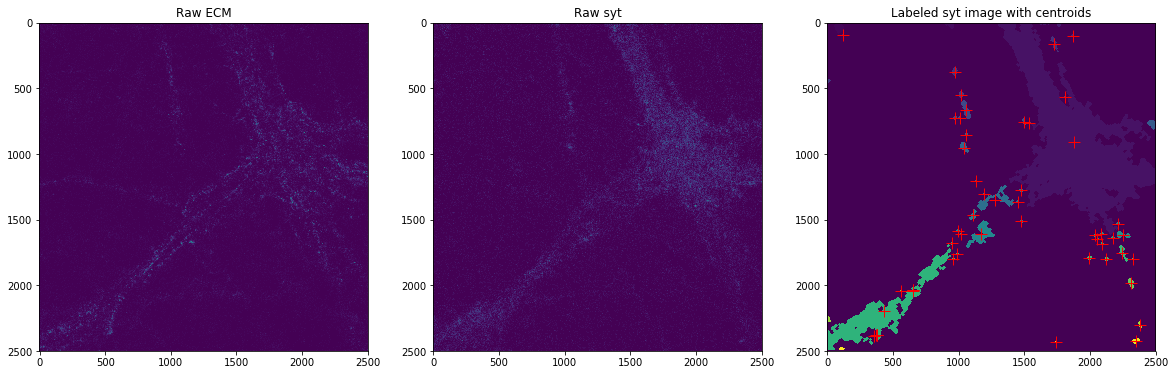

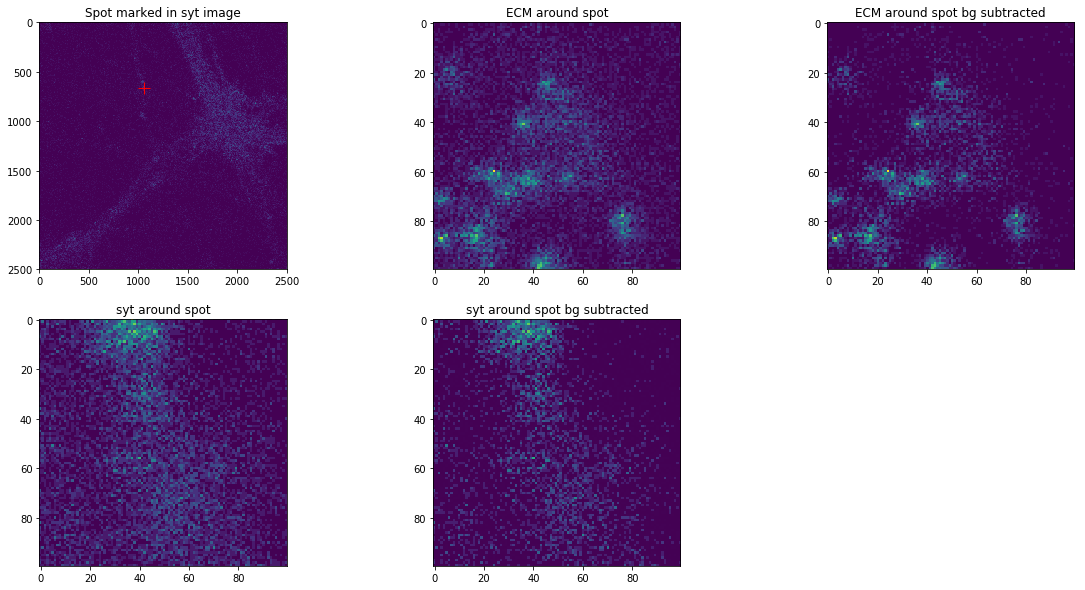

In [6]:
randomno=np.random.randint(1,len(results["filename"]))


ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[]
                                 }

ecm_channel_no=results["ecmchannelno"][randomno]
ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
ecm_image=pims.open(ecm_image_name)[0]
synapse_channel_no=results["synapsechannelno"][randomno]
synapse_image_name=results["filename"][randomno]+" Ch"+str(synapse_channel_no)+" {0}.tif"
synapse_image=pims.open(synapse_image_name)[0]
#label images
spots_mask=results["Manual syt spots mask"][randomno]
spots_labeled, cc_num=ndi.label(spots_mask)
#cut out ecm image 4microns around each spot - 200pixels
print(cc_num)
regions = regionprops(spots_labeled)
#fig, ax = plt.subplots(figsize=(10,10))
#ax.imshow(spots_mask,cmap=plt.cm.gray)
synapse_spots_results_sanity=[]
for props in regions:    
    y0, x0 = props.centroid
    center_of_spot=[0,0]
    center_of_spot[0]=np.round(y0).astype(int)
    center_of_spot[1]=np.round(x0).astype(int)
    #check if the spot gets cut off at the border before taking
    if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
        #cut out the ecm around spot
        ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        #cut out the synapse around spot
        original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
              center_of_spot[1]-50:center_of_spot[1]+50]
        if ecm_around_spot.shape==(100,100):
            #save centroid
            synapse_spots_results_sanity.append(props.centroid)
            ecm_distribution_around_synapses["filename"].append(results["filename"][randomno])
            ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][randomno])
            #append mean synapse intensity at spot
            mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
            ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
            #append synapse spot matrix
            ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
            #append ecm spot matrix
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

            #after bg subtraction
            ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
            ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
            bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
            ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
            ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

            synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
            synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
            bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
            synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
            synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

            ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
            ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
            ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
            ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))

fig=plt.figure(figsize=(20,10))
fig.add_subplot(131)
plt.title('Raw ECM')
plt.imshow(ecm_image)

fig.add_subplot(132)
plt.title('Raw syt')
plt.imshow(synapse_image)

fig.add_subplot(133)
plt.title('Labeled syt image with centroids')
plt.imshow(spots_labeled)
for i in range(0,len(synapse_spots_results_sanity)):
    plt.plot(synapse_spots_results_sanity[i][1],synapse_spots_results_sanity[i][0],'+',color='r',markersize=12)

#show random spot
randomno=np.random.randint(1,len(ecm_distribution_around_synapses))
centroid=synapse_spots_results_sanity[randomno]
fig=plt.figure(figsize=(20,10))
fig.add_subplot(231)
plt.title('Spot marked in syt image')
plt.imshow(synapse_image)
plt.plot(synapse_spots_results_sanity[randomno][1],synapse_spots_results_sanity[randomno][0],'+',color='r',markersize=12)

fig.add_subplot(232)
plt.title('ECM around spot')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot"][randomno])

fig.add_subplot(233)
plt.title('ECM around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"][randomno])

fig.add_subplot(234)
plt.title('syt around spot')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot"][randomno])

fig.add_subplot(235)
plt.title('syt around spot bg subtracted')
plt.imshow(ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"][randomno])

## Cut out 2x2 microns around each spot

In [7]:
#regionprops centroid = center of spot
ecm_distribution_around_synapses={"filename":[],
                                  "exp condition":[],
                                  "ecm_around_single_spot":[],
                                  "ecm_around_single_spot_mean_intensity":[],
                                  "ecm_around_single_spot bg subtracted":[],
                                  "ecm_around_single_spot_mean_intensity bg subtracted":[],
                                  
                                  "original_synapse_at_single_spot":[],
                                  "mean_intensty_original_synapse":[],
                                  "original_synapse_at_single_spot bg subtracted":[],
                                  "mean_intensty_original_synapse bg subtracted":[]}
                                  
for i in range(0,len(results["filename"])):
    #read the image
    ecm_channel_no=results["ecmchannelno"][i]
    ecm_image_name=results["filename"][i]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    synapse_channel_no=results["synapsechannelno"][i]
    synapse_image_name=results["filename"][i]+" Ch"+str(synapse_channel_no)+" {0}.tif"
    synapse_image=pims.open(synapse_image_name)[0]
    
    #label connected components in spots mask
    spots_mask=results["Manual syt spots mask"][i]
    spots_labeled, cc_num=ndi.label(spots_mask)
    #cut out ecm around spots - 100px by 100px (2x2 microns) 
    print('No spots in image: ' + str(cc_num))
    regions = regionprops(spots_labeled)
    for props in regions:
        y0, x0 = props.centroid
        center_of_spot=[0,0]
        center_of_spot[0]=np.round(y0).astype(int)
        center_of_spot[1]=np.round(x0).astype(int)
        #check if the spot gets cut off at the border before taking
        if (((center_of_spot[1]-50>0) & (center_of_spot[1]+50>0))&((center_of_spot[0]-50>0) & (center_of_spot[0]+50>0))):
            #cut out the ecm around spot
            ecm_around_spot=ecm_image[center_of_spot[0]-50:center_of_spot[0]+50,
                  center_of_spot[1]-50:center_of_spot[1]+50]
            #cut out the synapse around spot
            original_synapse_at_single_spot=synapse_image[center_of_spot[0]-50:center_of_spot[0]+50,
                  center_of_spot[1]-50:center_of_spot[1]+50]
            if ecm_around_spot.shape==(100,100):
                ecm_distribution_around_synapses["filename"].append(results["filename"][i])
                ecm_distribution_around_synapses["exp condition"].append(results["exp condition"][i])
                #append mean synapse intensity at spot
                mean_intensty_original_synapse=np.mean(original_synapse_at_single_spot)
                ecm_distribution_around_synapses["mean_intensty_original_synapse"].append(mean_intensty_original_synapse)
                #append ecm spot matrix
                ecm_distribution_around_synapses["ecm_around_single_spot"].append(ecm_around_spot)
                #append synapse spot matrix
                ecm_distribution_around_synapses["original_synapse_at_single_spot"].append(original_synapse_at_single_spot)
                #append ecm spot matrix
                ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity"].append(np.nanmean(ecm_around_spot))

                #after bg subtraction
                ecm_around_spot_bgsub=np.array(deepcopy(ecm_around_spot))
                ecm_around_spot_bgsub=np.divide(ecm_around_spot_bgsub,255)
                bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
                ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
                ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0

                synapse_around_spot_bgsub=np.array(deepcopy(original_synapse_at_single_spot))
                synapse_around_spot_bgsub=np.divide(synapse_around_spot_bgsub,255)
                bg_synapse=np.mean(ndi.median_filter(synapse_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(synapse_around_spot_bgsub,size=5))
                synapse_around_spot_bgsub=np.subtract(synapse_around_spot_bgsub,bg_synapse)
                synapse_around_spot_bgsub[synapse_around_spot_bgsub<0]=0

                ecm_distribution_around_synapses["mean_intensty_original_synapse bg subtracted"].append(np.nanmean(synapse_around_spot_bgsub))
                ecm_distribution_around_synapses["ecm_around_single_spot bg subtracted"].append(ecm_around_spot_bgsub)
                ecm_distribution_around_synapses["original_synapse_at_single_spot bg subtracted"].append(synapse_around_spot_bgsub)
                ecm_distribution_around_synapses["ecm_around_single_spot_mean_intensity bg subtracted"].append(np.nanmean(ecm_around_spot_bgsub))            

No spots in image: 169
No spots in image: 121
No spots in image: 56
No spots in image: 109
No spots in image: 154
No spots in image: 187
No spots in image: 140
No spots in image: 133
No spots in image: 87
No spots in image: 117
No spots in image: 159
No spots in image: 128
No spots in image: 142
No spots in image: 79
No spots in image: 245
No spots in image: 84
No spots in image: 126
No spots in image: 95
No spots in image: 164
No spots in image: 194
No spots in image: 264
No spots in image: 81
No spots in image: 164
No spots in image: 82
No spots in image: 211
No spots in image: 170
No spots in image: 121
No spots in image: 274
No spots in image: 99
No spots in image: 128
No spots in image: 59
No spots in image: 59
No spots in image: 42
No spots in image: 72
No spots in image: 84
No spots in image: 55
No spots in image: 102
No spots in image: 155
No spots in image: 167
No spots in image: 144
No spots in image: 122
No spots in image: 35
No spots in image: 130
No spots in image: 113
No 

## Make a dataframe of ECM/syt in spots

In [8]:
df=pd.DataFrame(ecm_distribution_around_synapses)
#add column names for plotting (drug, condition)
df['Time']='None'
df.loc[df["filename"].str.contains('2hr'), 'Time'] = '2hrs'
df.loc[df["filename"].str.contains('4hr'), 'Time'] = '4hrs'
df.loc[df["filename"].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'

df.loc[df['filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['filename'].str.contains('2hrs_Bic'), 'Condition'] = '2hr + Bic'
df.loc[df['filename'].str.contains('4hrs_Bic'), 'Condition'] = '4hr + Bic'
df.loc[df['filename'].str.contains('2hrs_DMSO'), 'Condition'] = '2hr + DMSO'
df.loc[df['filename'].str.contains('4hrs_DMSO'), 'Condition'] = '4hr + DMSO'
df.loc[df['filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df.loc[df['filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['filename'].str.contains('20181002'), 'expname'] = '20181002'
df.loc[df['filename'].str.contains('20181011'), 'expname'] = '20181011'
df.loc[df['filename'].str.contains('20181116'), 'expname'] = '20181116'

#new df, for adding means normalized to the median of the correspondig experiment
df2=deepcopy(df[df["Time"]=="12hrs"])
df2=df2.reset_index()
df2["ecm mean int norm2med"]=df2["ecm_around_single_spot_mean_intensity bg subtracted"]
df2["syt mean int norm2med"]=df2["mean_intensty_original_synapse bg subtracted"]

## Look at a random spot image

Text(0.5, 1.0, 'ECM around synapse spot bg subtracted')

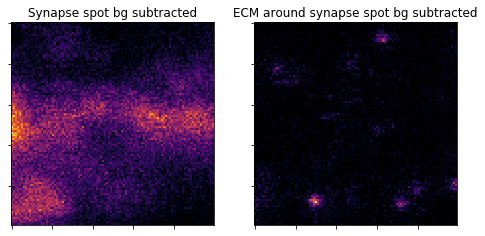

In [9]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(df["original_synapse_at_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('Synapse spot bg subtracted')
fig.add_subplot(122)
plt.imshow(df["ecm_around_single_spot"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot bg subtracted')

## Iterate over dataframe to add means normalized to median of experiment

In [10]:
expnam=[]
medtnr=[]
medsyt=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    med_tnr=dfexp["ecm_around_single_spot_mean_intensity bg subtracted"].median()
    med_syt=dfexp["mean_intensty_original_synapse bg subtracted"].median()
    print(exp+' - med tnr: '+str(med_tnr)+' - med syt: '+str(med_syt))
    expnam.append(exp)
    medtnr.append(med_tnr)
    medsyt.append(med_syt)
df2["ecm mean int norm2med"]=np.nan
df2["syt mean int norm2med"]=np.nan
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[0]
        df2["syt mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medsyt[0]
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[1]
        df2["syt mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medsyt[1]
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2med"][i]=df2["ecm_around_single_spot_mean_intensity bg subtracted"][i]/medtnr[2]
        df2["syt mean int norm2med"][i]=df2["mean_intensty_original_synapse bg subtracted"][i]/medsyt[2]

20181002 - med tnr: 0.0035072105882352944 - med syt: 0.007297225490196078
20181011 - med tnr: 0.003285102666666666 - med syt: 0.0031213255294117647
20181116 - med tnr: 0.002650112117647059 - med syt: 0.003286833352941176


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.p

## Outlier removal - 99th percentile

In [11]:
df2=df2[df2["ecm mean int norm2med"]<
               df2["ecm mean int norm2med"].quantile(.99)]
df2=df2[df2["syt mean int norm2med"]<
               df2["syt mean int norm2med"].quantile(.99)]

## Split data into 5 ordinal bins containing an equal no. of spots

In [12]:
##sort df according to synapse intensity
df3=deepcopy(df2)
df3=df3.sort_values("syt mean int norm2med",ascending=True)
df3=df3.reset_index(drop=True)
#split into 5 separate dfs, add column with number
a, b, c,d,e = np.split(df3, [int(.2*len(df3)),int(.4*len(df3)),int(.6*len(df3)),int(.8*len(df3))])
a['Synapse mean intensity ordinal bin']=0
b['Synapse mean intensity ordinal bin']=1
c['Synapse mean intensity ordinal bin']=2
d['Synapse mean intensity ordinal bin']=3
e['Synapse mean intensity ordinal bin']=4
#combine split dfs into one
dfnew=pd.concat([a,b,c,d,e],axis=0,ignore_index=True)

## Dataframe for means of individual experiments

In [13]:
synapse_bin_type='Synapse mean intensity ordinal bin'
means_in_bins_exps={"Exp name":[],"bin number":[],"mean syt":[],"mean tnr":[],"number of spots":[],
                    "mean syt int in bin overall":[]}
for exp in dfnew["expname"].unique():
    dfexp=dfnew[dfnew["expname"]==exp]
    for i in range(0,5):       
        mean_in_bin=dfnew[dfnew[synapse_bin_type].astype(int)==i]["syt mean int norm2med"].mean()
        dfplot=dfexp[(dfexp[synapse_bin_type].astype(int)==i)&
                    (dfexp["Time"]!="Unblocked Control")]
        means_in_bins_exps["Exp name"].append(exp)
        means_in_bins_exps["bin number"].append(i)
        means_in_bins_exps["mean syt int in bin overall"].append(mean_in_bin)
        means_in_bins_exps["mean syt"].append(dfplot["syt mean int norm2med"].mean())
        means_in_bins_exps["mean tnr"].append(dfplot["ecm mean int norm2med"].mean())
        nosynapses=len(dfplot)
        means_in_bins_exps["number of spots"].append(nosynapses)
dfmeans=pd.DataFrame(means_in_bins_exps)
dfmeans["mean syt int in bin overall"]=np.around(dfmeans["mean syt int in bin overall"],1)

## Plot

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


<Figure size 432x288 with 0 Axes>

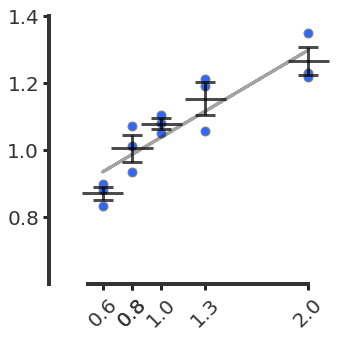

In [14]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.despine()
sns.set_palette("Set2")
var="mean tnr"
fig=plt.figure(figsize=(5,5))
g=sns.scatterplot(x="mean syt int in bin overall",y="mean tnr",
                data=dfmeans,s=80,color="#2F67F8",linewidth=1,edgecolor='grey')

plt.errorbar(x = dfmeans["mean syt int in bin overall"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=[dfmeans[dfmeans["bin number"]==0][var].sem(),
                   dfmeans[dfmeans["bin number"]==1][var].sem(),
                   dfmeans[dfmeans["bin number"]==2][var].sem(),
                   dfmeans[dfmeans["bin number"]==3][var].sem(),
                   dfmeans[dfmeans["bin number"]==4][var].sem()],
             xerr=None,ecolor='black',fmt='none',capsize=10,linewidth=3,capthick=3,alpha=.7,)

plt.errorbar(x = dfmeans["mean syt int in bin overall"].unique()
,
             y=[dfmeans[dfmeans["bin number"]==0][var].mean(),
                dfmeans[dfmeans["bin number"]==1][var].mean(),
                dfmeans[dfmeans["bin number"]==2][var].mean(),
                dfmeans[dfmeans["bin number"]==3][var].mean(),
                dfmeans[dfmeans["bin number"]==4][var].mean()],
             yerr=None,
             xerr=[.14,.14,.14,.14,.14],ecolor='black',fmt='none',capsize=0,linewidth=3,capthick=3,alpha=.7,)


plt.rcParams['font.sans-serif'] = 'Helvetica'
g.grid(False)
plt.ylim([0.6,1.41])
plt.xlim([0.3,2.2])

#fit linear curve
x=dfmeans["mean syt int in bin overall"]
y=dfmeans["mean tnr"]
m,b = np.polyfit(x, y, 1) 
plt.plot( x, m*x+b, 'k',linestyle='dashed',alpha=.4,linewidth=3) 

#formatting
g.xaxis.set_tick_params(width=3)
g.yaxis.set_tick_params(width=3)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(4)
  g.spines[axis].set_color('#333333')
  g.spines[axis].set_alpha(1)
offsets={"left":10,"bottom":0}
trims={"left":True,"bottom":True,"right":False}
sns.despine(ax=g,right=True,top=True,bottom=False,trim=trims,offset=offsets)
g.set_ylabel('')
g.set_xlabel('')
plt.yticks([0.8,1,1.2,1.4],color='#333333',size=20)
plt.xticks([0.6,0.8,0.8,1,1.3,2],color='#333333',size=20,rotation=45)

diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"
fig.savefig(diri+'3b_tnrsytcorr.svg', bbox_inches='tight', format='svg')

## Calculate Spearmans

In [16]:
from scipy.stats import spearmanr
[spearman, pval]=spearmanr(dfmeans["mean tnr"],dfmeans["mean syt int in bin overall"])
print(str(spearman))
print(pval)

0.9274260335029676
6.488928072016145e-07


## Calculate the Pearson's R and significance

In [22]:
from pydoc import help
from scipy.stats.stats import pearsonr
[pearson, pval]=pearsonr(dfmeans["mean tnr"],dfmeans["mean syt int in bin overall"])
print(str(pearson**2))
print(pval)

0.790829121721133
9.19296311025351e-06


## No. synapses in each bin

In [25]:
for bin in dfnew["Synapse mean intensity ordinal bin"].unique():
    print(len(dfnew[dfnew["Synapse mean intensity ordinal bin"]==bin]))

1168
1169
1168
1169
1169
